# Structural Model

Essentially a rocket is a long tube, with a tapered nose, fins at the base, and internal parts distributed along the length. The location of parts is fixed, but the mass within propellant tanks and N2 tanks will change throughout flight.

For simplicity, we will assume each internal part is axially symmetrical, and specify them by their forward position in the body-frame coordinates, material, forward position from the tip of the nose, axial length, and radius. This gives us the flexibility to add rigid bodies to our structural model that give us a more realistic moment of inertia.

## Fin Geometry
For our fin geometry, [this](http://www.efunda.com/math/areas/Trapezoid.cfm) and [this](http://mathworld.wolfram.com/Trapezoid.html) are a useful resources.
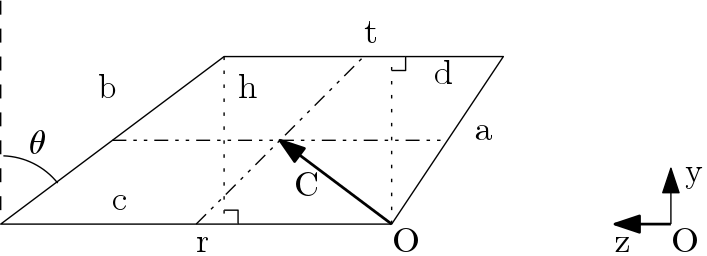

The geometry of a fin is determined by the root chord ($r$), tip chord ($t$), height ($h$), and sweep angle ($\theta$). By the definition of cosine and the Pythagorean Theorem, we immediately deduce that
$$b = \frac{h}{\sin(\pi/2 - \theta)},$$
$$c = \sqrt{b^2 - h^2},$$
$$a = \sqrt{h^2 + d^2}.$$
By inspection, we can see that $$d = t - (r - c) = t - r + c.$$
WolframAlpha provides equations for the centroid (i.e., center of mass) of a general trapezoid, which is the intersection of the medians (which bisect each side). Fixing the origin at $O$, to find the centroid $C$ in the provided frame, we have
$$z_c = r/2 + \frac{(2t+r)(a^2-b^2)}{6(r^2 - t^2)},$$
$$y_c = \frac{r+2t}{3(r+t)}h.$$
Recall that the x-axis is normal to the surface of the screen, so $x_c = 0$ by stipulation.

The area of a trapezoid is given by $$A = \frac{h(r+t)}{2}.$$
So given a thickness and density and assuming they are uniform, we can obtain a rough approximation of the mass of the fins.

Note that this solution is somewhat inefficient. It may be best to construct fins as a set rather than individually so that we only need to calculate the axial center of mass, since the fins are equally balanced in the x-y plane.

For the sake of time, we will take a cue from OpenRocket and simply assume our fins are rectangles for the purpose of calculating their moments of inertia. If further accuracy is required, we can decompose a trapezoidal fin into two triangles and a rectangle, assume they are "thin" and use a combination of known formulas for MoI and the parallel and perpindicular axis theorems to derive more accurate MoI.

Similarly, for the nosecone, we will assume that approximating it by a cone on a cylinder is sufficient for determining the mass, center of mass, and moment of inertia.

Estimated Bulkhead Mass: 493 g
Maximum Tank Length: 4 ft
Design inner diameter: 11 in
nosecone is 2 layers CF until halfway, then 2 CF, 1 Nmx. airframe is 2 CF, 1 Nmx except avionics which is 2 FG, 1 Nmx. Recovery, RCS, and tank passthru are alum

In [1]:
%run System_Definition.ipynb
import math
import numpy as np

# this class is for determining generic geometric properties of uniformly dense and symmetrical objects
# namely, how much space the material occupies and how mass is distributed
class Geometry:
    def __init__(self, shape):
        self.shape = shape
    def volume(self, axial, radial, thickness): # to be clear, this is the volume occupied, not volume contained
        if self.shape == 'Point':
            return 0
        elif self.shape == 'Shell':
            return axial * math.pi * ((radial + thickness)**2 - radial**2)
        elif self.shape == 'Blob':
            return (4 * math.pi / 3) * (axial/2) * radial**2
        elif self.shape == 'Fin':
            return thickness[0] * thickness[1] * (axial + radial) / 2 # these names are not descriptive here
        elif self.shape == 'Cone':
            return (1/3) * math.pi * (axial * radial**2 - (axial - thickness) * (radial - thickness)**2)
        
    # each moment of inertia is centered on component's center of mass in component's frame of reference
    # use parallel axis thm to find moments for superstructures
    def moment(self, mass, params):
        if self.shape == 'Point': # input position relative to some frame
            return mass * np.diag([np.linalg.norm(np.cross(np.array([1,0,0]), params))**2,
                                   np.linalg.norm(np.cross(np.array([0,1,0]), params))**2,
                                   np.linalg.norm(np.cross(np.array([0,0,1]), params))**2])
        elif self.shape == 'Shell':
            return (mass / 12) * np.diag([3 * (params[1]**2 + params[2]**2) + params[0]**2,
                                          3 * (params[1]**2 + params[2]**2) + params[0]**2,
                                          6 * (params[1]**2 + params[2]**2)])
        elif self.shape == 'Blob':
            return (mass / 5) * np.diag([(params[(i + 1) % 3]**2 + params[(i + 2) % 3]**2)
                                         for i in range(3)])
        elif self.shape == 'Fin':
            return (mass/12) * np.diag([(params[(i + 1) % 3]**2 + params[(i + 2) % 3]**2)
                                         for i in range(3)])
        elif self.shape == 'Cone':
            return (3*mass/5) * np.diag([params[0]**2 + params[1]**2 / 4,
                                         params[0]**2 + params[1]**2 / 4,
                                         params[1]**2 / 2])

# This class is for organizing the properties of individual components of the rocket
class Component:
    def __init__(self, name, material, length, radius, thickness, shape):
        self.name = name
        self.material = material
        self.length = length
        self.radius = radius
        self.thickness = thickness
        self.geo = Geometry(shape)
        self.volume = self.geo.volume(length, radius, thickness)
        self.mass = self.volume * material['rho'] if shape != 'Point' else material # for point-masses
        
        if shape == 'Point':
            self.moment = self.geo.moment(self.mass, np.array([0,0, length/2]))
        elif shape == 'Shell':
            self.moment = self.geo.moment(self.mass, [radius, radius+thickness, length])
        elif shape == 'Blob':
            self.moment = self.geo.moment(self.mass, [radius, radius, length])
        elif shape == 'Cone':
            self.moment = self.geo.moment(self.mass, [length, radius])
    
    # components are told where they are when created, relative to base of rocket
    def center_of_mass(self, coords_rear):
        if self.geo.shape == 'Cone':
            self.CoM = coords_rear + np.array([0,0, self.length/4])
        else:
            self.CoM = coords_rear + np.array([0, 0, self.length/2])

# fins require special calculations to determine their center of mass relative to the rocket
# because they are not located down the axis of symmetry
# at some point, consolidate most of the fin-related calculations from the aero model into this class, low priority
class Fin(Component):
    def __init__(self, name, material, root, tip, sweep, semispan, thickness):
        self.name = name
        self.material = material
        self.root = root
        self.tip = tip
        self.sweep = sweep
        self.semispan = semispan
        self.thickness = thickness
        self.geo = Geometry('Fin')
        self.volume = self.geo.volume(root, tip, [semispan, thickness])
        self.mass = self.volume * material['rho']
        if name == 'Front' or name == 'Back':
            self.moment = self.geo.moment(self.mass, [thickness, semispan, root])
        else:
            self.moment = self.geo.moment(self.mass, [semispan, thickness, root])
        
    def center_of_mass(self, coords_rear):
        leg_b = self.semispan / np.sin(math.pi/2 - self.sweep)
        c = np.sqrt(leg_b**2 - self.semispan**2)
        d = self.tip + c - self.root
        leg_a = np.sqrt(d**2 + self.semispan**2)
        self.sweep_length = c
        x = 0
        y = (self.semispan/3) * (self.root + 2*self.tip)/(self.root + self.tip)
        z = self.root/2 + (2*self.tip + self.root)*(leg_a**2 - leg_b**2)/(3*(self.root + self.tip))
        if self.name == 'Front':
            self.CoM = coords_rear + np.array([x, y, z])
        elif self.name == 'Back':
            self.CoM = coords_rear + np.array([x, -y, z])
        elif self.name == 'Left':
            self.CoM = coords_rear + np.array([y, x, z])
        elif self.name == 'Right':
            self.CoM = coords_rear + np.array([-y, x, z])

# engines and rcs nozzles don't have special geometry but they have many dynamic properties in the simulation
# this class exists because there isn't much difference between hot gas and cold gas thrusters
# and it will make simulation code more readable when we call thrust function
class Engine(Component):
    def __init__(self, mdot, p_e, p_ch, T_ch, ke, MM, throttle_window, min_throttle, is_RCS):
        if is_RCS:
            Component.__init__(self, 'Gas Jet', Alum, 0.14, 0.07, 0, 'Blob')
        else:
            Component.__init__(self, 'Engine', Alum, 0.3, .1, .011, 'Shell')
            
        self.thrust_vector = np.array([0, 0, 1]) # as in, points straight up to the nose
        self.mdot = mdot
        self.p_e = p_e
        self.empty = False
        self.p_ch = p_ch
        self.T_ch = T_ch
        self.ke = ke
        self.MM = MM
        self.Re = R_univ / MM
        self.throttle = [1.]
        self.min_throttle = min_throttle
        self.can_throttle = False if min_throttle == 1. else True
        self.throttle_window = throttle_window
        self.throttle_rate = (min_throttle - 1.) / (throttle_window[1] - throttle_window[0])
        self.throttle_y_intercept = 1. - self.throttle_rate * throttle_window[0]
        
        # Throat pressure      [Pa]
        self.p_t = p_ch * (1 + (ke - 1)/2)**(-ke /(ke - 1))
        # Throat temperature   [K]
        self.T_t = T_ch*(1 / (1 + (ke - 1)/2))
        # Throat area          [m^2]
        self.A_t = (mdot / self.p_t) * np.sqrt(self.Re * self.T_t / ke)
        # Expansion ratio
        self.ex = (2 / (ke + 1))**(1 / (ke - 1)) * (p_ch / p_e)**(1/ke) / np.sqrt(
                                        (ke + 1) / (ke - 1) * (1 - (p_e / p_ch)**(((ke - 1) / ke))))
        # Exit area [m^2] 
        self.A_e = self.ex * self.A_t
        
        L = 0.1 # m from throat to exit
        # divergence angle
        alpha = np.arctan((np.sqrt(self.A_e) - np.sqrt(self.A_t))/(L * np.sqrt(math.pi)))
        # Thrust divergence losses correction,
        self.lam = 0.5 * (1 + np.cos(alpha))
        self.exhaust_velocity(p_ch)
        
    # Exhaust velocity       [m/s]
    def exhaust_velocity(self, p_ch):
        if p_ch <= self.p_e:
            self.Ve = 0
            self.empty = True
        else:
            self.Ve = self.lam * np.sqrt(2*self.ke / (self.ke - 1) * self.Re * self.T_ch *
                             (1 - (self.p_e/p_ch)**((self.ke - 1)/self.ke)))
    
    # linear throttle for simplicity
    def throttle_engine(self, drag):
        if self.can_throttle == False:
            return 1.
        elif drag <= self.throttle_window[0]:
            return 1.
        elif drag >= self.throttle_window[1]:
            return self.min_throttle
        else:
            return drag * self.throttle_rate + self.throttle_y_intercept
    
    # calculates engine thrust at a height
    def thrust(self, p_a, thrtl):
        return thrtl*self.mdot*self.Ve + (self.p_e - p_a)*self.A_e

# this class is the workhorse we ride into the sunset
# essentially it is a list of parts that are either components or lists of parts
# but each list also has properties as an assemblage that are a result of its parts
# so we can recursively determine or print every material property of the rocket by one function call
class Structure:
    def __init__(self, name, static=False):
        self.name = name
        self.static = static
        self.parts = []
    def add_part(self, coords, name, material, length, radius, thickness, shape):
        self.parts.append(Component(name, material, length, radius, thickness, shape))
        self.parts[-1].center_of_mass(coords)
    def add_fin(self, coords, name, material, root, tip, sweep, semispan, thickness):
        self.parts.append(Fin(name, material, root, tip, sweep, semispan, thickness))
        self.parts[-1].center_of_mass(coords)
    def add_engine(self, coords, mdot, p_e, p_ch, T_ch, ke, Re, throttle_window, min_throttle, is_RCS):
        if is_RCS:
            self.parts.append(RCS(mdot, p_e, p_ch, T_ch, ke, Re, throttle_window, min_throttle, is_RCS))
        else:
            self.parts.append(Engine(mdot, p_e, p_ch, T_ch, ke, Re, throttle_window, min_throttle, is_RCS))
        self.parts[-1].center_of_mass(coords)
    def add_structure(self, struct):
        self.parts.append(struct)
    def sum_parts(self):
        def parallel_axis(CoM_S, CoM_P, I, m):
            delta = CoM_P - CoM_S
            return I + m * (np.dot(delta, delta)*np.diag([1,1,1]) - np.outer(delta, delta))
        
        for i, part in enumerate(self.parts):
            if hasattr(part, 'parts') and (not self.static or not hasattr(part, 'moment')):
                part.sum_parts()
                
        self.mass = sum([p.mass for p in self.parts])
        self.CoM = np.sum([p.CoM * p.mass for p in self.parts],
                          axis=0) / self.mass
        self.moment = np.sum([parallel_axis(self.CoM,
                                            p.CoM,
                                            p.moment,
                                            p.mass) for p in self.parts], axis=0)
        
    def read_out(self, description=[], indents=0):
        if indents==0:
            self.description = []
            description = self.description
            self.description.append(self.name + "\tGLOW:" + str(self.GLOW) + "\tCurrent Mass:" + str(self.mass) + '\n')
        for i, part in enumerate(self.parts):
            name_space = "\t"* (indents + 4 - len(part.name) // 8)
            spacing = indents * "\t"
            description.append("  " * indents + str(i) + ".\t" + spacing +
                                    part.name + name_space + "Mass: " + str(round(part.mass, 2))  + '\n')
            if hasattr(part, 'parts'):
                part.read_out(description, indents + 1)
    #def axial_load(self):
    #    if not hasattr(part, 'parts'):
    #        return
    #    mass_above = sum([part.])

class Module(Structure):
    def __init__(self, coords, name, material, length, radius, shape='Shell'):
        self.name = name
        self.parts = []
        self.coords = coords
        self.length = length
        self.static = True
        # airframe layup layer: material, distance from ID, thickness
        if material is Alum: # for micromodules
            layers = [[material, 0, 0.008255]]
        elif shape == 'Shell': # for composite modules
            layers = [[material, 0, 0.000635],
                      [Nomex, 0.000635, 0.00635],
                      [material, 0.006985, 0.00127]]
        else: # for nosecone
            layers = [[material, 0, 0.00127]]
            
        thickness = sum([layer[2] for layer in layers])
        
        for i in range(len(layers)):
                self.add_part(coords, name + ' Layer ' + str(i+1), layers[i][0],
                              length, radius + layers[i][1], layers[i][2], shape)
        if shape == 'Shell': # so we don't add these to conical part of nosecone
            self.add_part(coords + np.array([0,0,length]), '2Rings&6Clamps', Alum,
                      0.056642, radius, thickness, 'Shell')
            self.add_part(coords, 'Bulkhead', Alum,
                        0.003175, 0.2, 0.05, 'Shell')
            self.add_part(coords + np.array([0,0,length]), 'Bulkhead', Alum,
                          0.003175, 0.2, 0.05, 'Shell')

class Nosecone(Structure):
    def __init__(self, coords, material, cyl_length, cone_length, radius, thickness):
        self.name = 'Nosecone'
        self.coords = coords
        self.parts = []
        self.length = cyl_length + cone_length
        self.static = True
        self.add_structure(Module(coords, 'Cylinder', material, cyl_length, radius))
        self.parts[-1].parts.pop() # throw away the upper bulkhead
        self.add_structure(Module(coords + np.array([0,0,cyl_length]), 'Cone', material, cone_length, radius, 'Cone'))
    
class Tank(Structure):
    def __init__(self, coords, material, in_radius, thickness,
                 prop_mass, prop_matrl, insulation, ullage=1.1, compressible=False):
        self.name = prop_matrl['name']+' Tank'
        self.prop_matrl = prop_matrl
        self.in_radius = in_radius
        self.coords = coords
        self.parts = []
        self.static = False
        fl_ht = self.fluid_height(prop_mass)
        self.compressible = compressible
        length = ullage * fl_ht
        self.length = length
        self.volume = length * np.pi * in_radius**2
        self.add_part(coords, 'Tank Walls', material, length, in_radius, thickness, 'Shell')
        if insulation != 0:
            self.add_part(coords, 'Insulation', Cryogel, length,
                          in_radius+thickness, 0.005*insulation, 'Shell')
        self.add_part(coords, 'Bottom Cap', material, 0.00254, 0, in_radius, 'Shell')
        self.add_part(coords + np.array([0,0,length]), 'Top Cap', material, 0.00254, 0, in_radius, 'Shell')
        if not compressible: # so we don't add these to N2 tank
            self.add_part(coords + np.array([0,0,length]), '2Rings&6Clamps', Alum,
                      0.056642, in_radius + 0.004445, 0.008255, 'Shell')
            self.add_part(coords, 'Bulkhead', Alum,
                        0.003175, 0.2, 0.05, 'Shell')
            self.add_part(coords + np.array([0,0,length]), 'Bulkhead', Alum,
                          0.003175, 0.2, 0.05, 'Shell')
        self.dry_m = sum([part.mass for part in self.parts])
        self.add_part(coords, 'Propellant', prop_matrl, fl_ht, 0, in_radius, 'Shell')

    def fluid_height(self, prop_mass):
        return prop_mass / (self.prop_matrl['rho'] * math.pi * self.in_radius**2)
    def drain(self, delta):
        prop = self.parts.pop()
        new_prop = prop.mass - abs(delta)
        if self.compressible: self.prop_matrl['rho'] = new_prop / self.volume
        new_ht = self.fluid_height(new_prop) if not self.compressible else self.length
        self.add_part(self.coords, 'Propellant', self.prop_matrl, new_ht, 0, self.in_radius, 'Shell')

class N2_tank(Tank):
    def __init__(self, coords, mdot, p_e, p_ch, T_ch, MM, ke, tank_l, tank_r, out_rad):
        self.mdot = mdot
        self.T_ch = T_ch
        self.MM = MM
        self.tank_V = tank_l * tank_r**2 * np.pi
        # use this to get N2 mass based on tank parameters
        self.gas_mass = self.ideal_mass(p_ch, self.tank_V, MM, T_ch) # kg
        
        super().__init__(coords, Alum, tank_r, 0.0027, self.gas_mass,
                         Material('N2', p_ch*MM/(R_univ * T_ch)), 0, 1, True)
        
    # at some point, include function for keeping fuel tanks pressurized (at what pressure??)
    def ideal_mass(self, P, V, M, T):
        return P * V * M / (T * R_univ)
    def pressure(self):
        return self.parts[-1].mass * self.T_ch * R_univ / (self.tank_V * self.MM)
    # at some point, introduce check to make sure we don't need rest of gas for fuel tanks
    def has_spare_gas(self):
        return self.parts[-1].mass > self.mdot# and not self.parts[1].empty
    
class RCS(Engine):
    def __init__(self, mdot, p_e, p_ch, T_ch, ke, MM, throttle_window, min_throttle, is_RCS):
        self.up = np.array([0,0,1]) # for convenience
        self.bang_on = 0.00872665 # radians
        self.bang_off = 0.00872665 # for now, no hysteresis
        self.active = False
        super().__init__(mdot, p_e, p_ch, T_ch, ke, MM, throttle_window, min_throttle, is_RCS)
        
    def controller(self, q, p_a, rkt_CoM):
        num_thrusters = 0
        up_body = frame_rotation(q, self.up)
        deviation = np.arccos(np.clip(np.dot(up_body, self.up), -1, 1))
        # kinda naive switching control
        if (self.tank.has_spare_gas() and
                ((not self.active and deviation >= self.bang_on) or
                (self.active and deviation >= self.bang_off))):
            self.active = True
            sign_vec = -np.sign((np.cross(self.up, np.cross(self.up, up_body))))
            num_thrusters = sum([abs(e) for e in sign_vec])
            rcs_thrust = self.thrust(p_a, 1.0)
            force = rcs_thrust * sign_vec
            actuators = self.out_rad*sign_vec + self.CoM - rkt_CoM
            torque = np.cross(actuators, force)
        else:
            self.active = False
            num_thrusters = 0
            force = np.zeros(3)
            torque = np.zeros(3)
        return (num_thrusters, force, torque)
        
class Rocket(Structure):
    def has_fuel(self):
        lox_1s, ipa_1s = proportion(self.engine.mdot/10, self.OF)
        return self.lox_tank.parts[-1].mass > lox_1s and self.ipa_tank.parts[-1].mass > ipa_1s

In [2]:
# when you are smarter, break this structure up into the most reasonable chunks so it's not so ad hoc
def create_rocket(mprop, mdot, p_e,
                  p_ch, T_ch, ke, MM,
                  throttle_window, min_throttle,
                  airfrm_in_rad, OF,
                  rcs_mdot, rcs_p_e, rcs_p_ch,
                  ballast, root, tip, sweep, span, thickness):
    
    m_o, m_f  = proportion(mprop, OF)
    out_rad   = airfrm_in_rad + airframe_thickness
    l_eng_sys = fin_can_l #l_feed + l_ems + l_engine # for convenience
    
    rocket  = Rocket('LV4')
    
    height = 0
    fin_root_height = 0.082525
    
    
    engine_subsystem = Structure('Engine Subsystem')
    engine_subsystem.add_structure(Module(np.array([0, 0, height]), 'Fin Can Module', CFiber, l_eng_sys, airfrm_in_rad))
    engine_subsystem.parts[-1].add_part(np.array([0, 0, height]), 'Thrust Collar', Alum, 0.01905, 0.0254, airfrm_in_rad-0.0254, 'Shell')
    engine_subsystem.parts[-1].add_engine(np.array([0, 0, height - 0.10993]), mdot, p_e, p_ch, T_ch, ke, MM, throttle_window, min_throttle, False)
    rocket.engine    = engine_subsystem.parts[-1].parts[-1] # for convenience
    engine_subsystem.parts[-1].add_part(np.array([0, 0, l_engine]), 'EMS', Alum, 0.1016, 0.041, 0, 'Blob')
    engine_subsystem.parts[-1].add_part(np.array([0, 0, l_engine + l_ems]), 'EFS', Alum, 0.4572, 0.0613, 0, 'Blob')
    
    rocket.add_structure(engine_subsystem.parts[-1])
    
    fin_set = Structure('Fins')
    fin_set.add_fin(np.array([0, out_rad, height + fin_root_height]), "Front", Alum, root, tip, sweep, span, thickness)
    fin_set.add_fin(np.array([0, -out_rad, height + fin_root_height]), "Back", Alum, root, tip, sweep, span, thickness)
    fin_set.add_fin(np.array([out_rad, 0, height + fin_root_height]), "Left", Alum, root, tip, sweep, span, thickness)
    fin_set.add_fin(np.array([-out_rad, 0, height + fin_root_height]), "Right", Alum, root, tip, sweep, span, thickness)
    rocket.fin = fin_set.parts[0]
    
    rocket.parts[-1].add_structure(fin_set)
    
    height += l_eng_sys + coupling_ring_ht
    
    rocket.add_structure(Module(np.array([0, 0, height]), 'Engine Passthru Module', Alum, pas_l, airfrm_in_rad))
    rocket.parts[-1].add_part(np.array([-out_rad, 0, height]), 'Launch Button', 0.2051, 0.02, 0, 0, 'Point')
    rocket.parts[-1].add_part(np.array([0, out_rad, height]), 'Pipe', Alum, 1.3604, 0.009525, 0.003175, 'Shell') # 1 in OD, 1/8th in thick
    rocket.parts[-1].add_part(np.array([out_rad, 0, height]), 'Pipe', Alum, 3.4209, 0.009525, 0.003175, 'Shell') # 1 in OD, 1/8th in thick
    height += pas_l + coupling_ring_ht
    
    engine_subsystem.add_structure(Tank(np.array([0, 0, height]), Alum, tank_in_rad, tank_eqv_wt_t, m_o, LOX, 2))
    rocket.m_tank_o = engine_subsystem.parts[-1].dry_m
    rocket.l_o      = engine_subsystem.parts[-1].parts[0].length
    rocket.lox_tank = engine_subsystem.parts[-1] # for convenience
    rocket.add_structure(engine_subsystem.parts[-1])
    height += rocket.l_o + coupling_ring_ht
    
    rocket.add_structure(Module(np.array([0, 0, height]), 'Tank Passthru Module', Alum, pas_l, airfrm_in_rad))
    rocket.parts[-1].add_part(np.array([-out_rad, 0, height]), 'Launch Button', 0.2051, 0.02, 0, 0, 'Point')
    rocket.parts[-1].add_part(np.array([0, -out_rad, height]), 'Pipe', Alum, 2.0096, 0.009525, 0.003175, 'Shell') # 1 in OD, 1/8th in thick
    height += pas_l + coupling_ring_ht
    
    engine_subsystem.add_structure(Tank(np.array([0, 0, height]), Alum, tank_in_rad, tank_eqv_wt_t, m_f, IPA, 0))
    rocket.m_tank_f = engine_subsystem.parts[-1].dry_m
    rocket.l_f      = engine_subsystem.parts[-1].parts[0].length
    rocket.ipa_tank = engine_subsystem.parts[-1] # for convenience
    rocket.add_structure(engine_subsystem.parts[-1])
    height += rocket.l_f + coupling_ring_ht
    
    #rocket.add_structure(engine_subsystem)
    rocket.eng_sys = engine_subsystem #rocket.parts[-1]
    rocket.eng_sys.sum_parts()
    
    rocket.add_structure(Module(np.array([0, 0, height]), 'AV Module', Fiberglass, av_l, airfrm_in_rad))
    rocket.parts[-1].add_part(np.array([0, 0, height]), 'AV/360', Alum, 0.3, .0433, 0, 'Blob')
    height += av_l + coupling_ring_ht
    
    rocket.add_structure(Module(np.array([0, 0, height]), 'N2 Passthru Module', Alum, pas_l, airfrm_in_rad))
    height += pas_l + coupling_ring_ht
    
    rocket.add_structure(Module(np.array([0, 0, height]), 'N2 Module', CFiber, n2_l, airfrm_in_rad))
    rocket.parts[-1].add_structure(N2_tank(np.array([0, 0, height]), rcs_mdot, rcs_p_e, rcs_p_ch,
                                          N2_temp, N2_MM, N2_ke, 0.45, 0.165/2, out_rad))
    rocket.rcs_tank = rocket.parts[-1].parts[-1] # for convenience
    height += n2_l + coupling_ring_ht
    
    rocket.add_structure(Module(np.array([0, 0, height]), 'RCS Module', Alum, rcs_l, airfrm_in_rad))
    rocket.parts[-1].add_engine(np.array([0,0, height]), rcs_mdot, rcs_p_e, rcs_p_ch, N2_temp, N2_ke, N2_MM, (200,100), 1, True)
    rocket.parts[-1].parts[-1].out_rad = out_rad
    rocket.parts[-1].parts[-1].tank = rocket.parts[-2].parts[-1]
    rocket.rcs_sys = rocket.parts[-1].parts[-1] # for convenience
    height += rcs_l + coupling_ring_ht
    
    rocket.add_structure(Module(np.array([0, 0, height]), 'ERS Module', Alum, ers_l, airfrm_in_rad))
    rocket.parts[-1].add_part(np.array([0, 0, height]), 'ERS', Alum, 0.1225, .07, 0, 'Blob')
    height += ers_l + coupling_ring_ht
    
    rocket.add_structure(Nosecone(np.array([0, 0, height]), CFiber, cyl_nose_l, con_nose_l, airfrm_in_rad, 0.00762))
    rocket.parts[-1].add_part(np.array([0, 0, height + 0.3]), 'Parachutes', Alum, 0.0575, .057, 0, 'Blob')
    height += nose_l
    rocket.parts[-1].add_part(np.array([0, 0, height - 0.2]), 'Ballast', max(ballast, 0), 0.1, 0, 0, 'Point')
    
    # could calculate this based on tank length
    rocket.lug_separation = 1.27 # m, between fore and aft launch lugs. 2.29 is other alternative
    rocket.tip_off_error = False
    rocket.drag_perturb = 1
    rocket.sum_parts()
    rocket.GLOW = rocket.mass
    rocket.m_o, rocket.m_f = m_o, m_f
    rocket.OF = OF
    rocket.inr_r = airfrm_in_rad
    rocket.diameter = out_rad*2
    rocket.length = height
    rocket.frontal_area = math.pi * out_rad**2
    rocket.eng_sys_dry_mass = rocket.m_tank_o + rocket.m_tank_f + engine_subsystem.parts[0].mass
    rocket.eng_sys_len = l_eng_sys + rocket.l_o + rocket.l_f + pas_l
    rocket.ballast = max(ballast, 0)    
    
    return rocket

In [ ]:
def structural_analysis(rkt, env, state):
    air, wind         = env.atmo(state[1])
    p_a, rho, T_a, mu = air
    x, q, v, w        = state[1:]
    # this is inefficient, but we're only only calling this function once, at max-q
    force_body, torque_body, v0, dyn_press, Ma, alpha, CoP, fin_flutter, CN, CDax = env.aero_model.aero(state, rkt, air, wind)
    
    mult              = dyn_press * rkt.frontal_area # for convenience
    # Aerodynamic Normal Forces
    CN_nose           = mult * alpha * env.aero_model.C_N_alpha_nose(alpha)
    CN_body           = mult * alpha * env.aero_model.C_N_alpha_lift(alpha)
    CN_fin            = mult * alpha * env.aero_model.normal_force_coefficient(alpha, Ma)
    
    # Aerodynamic Axial Forces, unadjusted for angle of attack
    # friction, nose pressure, fin pressure, base drag, parasitic drags
    # friction is whole rocket (for simplicity, assume evenly distributed, though fins account for some)
    # pipes are split between two isogrid tanks
    # lugs are split between lowest two passthru micromodules
    axial_drags       = env.aero_model.C_D_0(env.aero_model.Reynold(v0), Ma)
    # adjustment multiplier from angle of attack
    aoa_cd_mult       = env.aero_model.C_D_axial(alpha, 1)
    # Aerodynamic Axial Forces
    CD_f, CD_p1, CD_p2, CD_b, CD_pipes, CD_lugs = [mult * aoa_cd_mult * drag for drag in axial_drags]
    
    # Thrust axial force
    thrust            = rkt.engine.thrust(air[0], rkt.engine.throttle_engine(np.linalg.norm(force_body)))
    
    # distribute friction force by length
    friction_forces   = CD_f * np.array([part.length / (rkt.length - 10 * coupling_ring_ht)
                                         for part in reversed(rkt.parts)])
    # distribute pipe and lug forces to passthru modules (assume evenly for simplicity)
    passthru_modules  = np.array([int('Passthru' in part.name) for part in reversed(rkt.parts)])
    para_drag_per_mod = (CD_pipes + CD_lugs) / sum(passthru_modules)
    parasitic_drags   = passthru_modules * para_drag_per_mod
    other_ax_forces   = np.array([CD_p1, 0, 0, 0, 0, 0, 0, 0, 0, 0, CD_p2 + CD_b - thrust])
    # array of all axial forces
    axial_forces      = friction_forces + parasitic_drags + other_ax_forces
    
    # distribute body lift by length
    body_lifts        = CN_body * np.array([part.length / (rkt.length - nose_l - 10 * coupling_ring_ht)
                                            for part in reversed(rkt.parts)])
    body_lifts[0]     = 0 # nosecone already accounted for
    # other normal forces
    other_normals     = np.array([CN_nose, 0 ,0 ,0 , 0, 0, 0, 0, 0, 0, CN_fin])
    # array of all normal forces
    normal_forces     = body_lifts + other_normals
    
    # Total forces
    total_normal      = sum(normal_forces)
    total_axial       = sum(axial_forces)
    
    # Total mass
    total_mass        = rkt.mass
    
    # load factors
    lat_load_factor   = -total_normal / total_mass
    ax_load_factor    = -total_axial / total_mass
    
    # inertial loads
    intl_lat_loads    = lat_load_factor * np.array([part.mass for part in reversed(rkt.parts)])
    intl_ax_loads     = ax_load_factor * np.array([part.mass for part in reversed(rkt.parts)])
    
    # combined loads
    cmbn_lat_loads    = normal_forces + intl_lat_loads
    cmbn_ax_loads     = axial_forces + intl_ax_loads
    
    # load at tops
    lat_load_at_top   = np.zeros(11)
    for i, load_above in enumerate(lat_load_at_top):
        if i == 10:
            pass
        else:
            lat_load_at_top[i + 1] = cmbn_lat_loads[i] + load_above
            
    ax_load_at_top    = np.zeros(11)
    for i, load_above in enumerate(ax_load_at_top):
        if i == 10:
            pass
        else:
            ax_load_at_top[i + 1]  = cmbn_ax_loads[i] + load_above
            
    bending_moments   = np.zeros(11)
    for i, element in enumerate(reversed(rkt.parts)):
        if i == 10:
            pass
        else:
            shear_at_top           = lat_load_at_top[i] * element.length
            force_at_middle        = cmbn_lat_loads[i] * (element.CoM[2] - element.coords[2])
            bending_moments[i + 1] = bending_moments[i] + shear_at_top + force_at_middle
    
    return ax_load_at_top, lat_load_at_top, bending_moments
    